# Fisher Criterion Beamformer - spatial filter to extract features from P300 data
### Jupyter notebook version (Python Toolbox also available) 
For the purpose of this example, it is useful to know that the datasets use:   
 - 12 EEG channels: order [1-Fz 2-Cz 3-C3 4-C4 5-CPz 6-Pz 7-P3 8-P4 9-PO7 10-PO8 11-POz 12-Oz]
 - sampling frequency: fs = 256 Hz
 - dataset is filtered [1-10] Hz
 - epochs are all 1 second long

 - this example is self-explanatory from code and comments - just run and select the dataset
 - to show the discrimination effect of FCB r-square is applied on data before and after FCB filtering 

 If you use the FCB toolbox please refer to [1]
 If you use the datasets please refer to [2] and [3]

References:
- [1] Gabriel Pires, Urbano Nunes and  Miguel Castelo-Branco (2011), "Statistical Spatial Filtering for 
     a P300-based BCI: Tests in able-bodied, and Patients with Cerebral Palsy and Amyotrophic Lateral 
     Sclerosis", Journal of Neuroscience Methods, Elsevier, 2011, 195(2), 
     Feb. 2011: doi:10.1016/j.jneumeth.2010.11.016
     https://www.sciencedirect.com/science/article/pii/S0165027010006503?via%3Dihub
- [2] https://ieee-dataport.org/open-access/error-related-potentials-primary-and-secondary-errp-and-p300-event-related-potentials-%E2%80%93


@author: Gabriel Pires, February 2024


Importing some required Python libraries 

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('FCB_toolbox')
sys.path.append('rsquare')
import rsquare_fn
import FCB_toolbox

Loading the P300 dataset (obtained  from one of our communication spellers (LSC) [2])

In [3]:
data  = loadmat('data\P300_LSC_dataset.mat')
data.keys()
data1 = data['P300_LSC_dataset']   #structure with target and non-targets
data1.dtype                     
yt = data1[0,0]['ytarget']        #ytarget: channels x time sample x trials 
ynt = data1[0,0]['yNONtarget']
    
#the dataset is very imbalanced, so we may limit NONtarget trials to fewer trials , let's say 840
ynt = ynt[:,:, 0:840] 
    
label1='P300'
label2='Standard' 
    
print('P300 DATASET\n')
print('Variable yt:   P300 epochs     -  channels x  time samples x  target trials \n', np.size(yt,0),np.size(yt,1),np.size(yt,2));
print('Variable ynt:  standard epochs -  channels x  time samples x  NONtarget trials \n', np.size(ynt,0),np.size(ynt,1),np.size(ynt,2));


P300 DATASET

Variable yt:   P300 epochs     -  channels x  time samples x  target trials 
 12 256 90
Variable ynt:  standard epochs -  channels x  time samples x  NONtarget trials 
 12 256 840


## Plotting the mean and standard deviation of Target (P300) and Nontarget Event-Related Potentials 

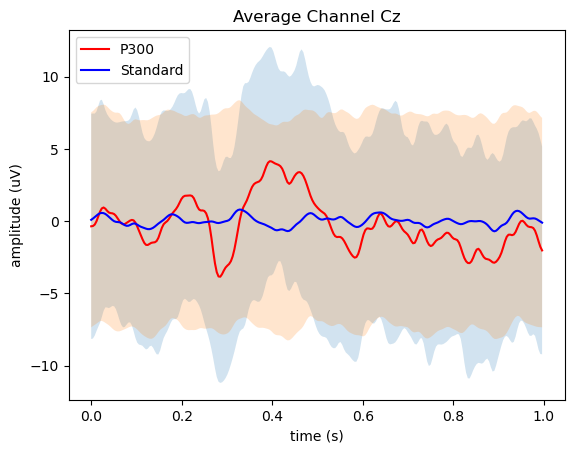

In [4]:
fs = 256;                             # sampling frequency: 256 Hz
Ts = 1/ fs;
#t=[0 : 256-1]*1/fs;                  # 1 second trial

x = np.arange(fs);
t = np.multiply(x,Ts)

# Average of data (targets (ErrPs) and non-targets (Correct ERPs))
yt_mean = np.mean(yt, axis=2) 
yt_std  = np.std(yt,axis=2);
ynt_mean = np.mean(ynt,axis=2)
ynt_std  = np.std(ynt,axis=2)
#np.size(yt,2)

#plot average
ch = 2  # channel Cz
#ax1 = plt.subplot(3,1,1)
plt.plot(t,yt_mean[ch,:],'r',label=label1)
plt.plot(t,ynt_mean[ch,:],'b', label=label2)
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average Channel Cz')
plt.legend(loc = 'upper left')
plt.fill_between(t,yt_mean[ch,:]+yt_std[ch,:], yt_mean[ch,:]-yt_std[ch,:], alpha=0.2)
plt.fill_between(t,ynt_mean[ch,:]+ynt_std[ch,:], ynt_mean[ch,:]-ynt_std[ch,:], alpha=0.2)
plt.show()


## Functions for Feature discrimination and colormap plot

from https://www.bci2000.org/mediawiki/index.php/Glossary#r-squared

r2 version adjusted to Python
and r2 color map visualization

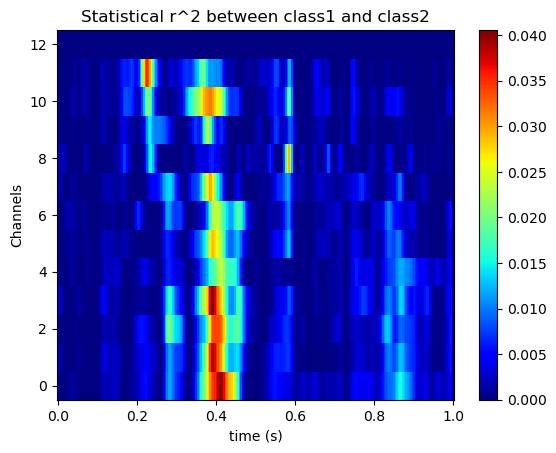

In [5]:
N_ch = np.size(yt, 0);              #channels
N_samp = np.size(yt, 1);            #time samples
rsq = np.zeros((N_samp, N_ch));     #initialize variable
#np.size(rsq,0)

#ax2 = plt.subplot(3,1,2)
#plt.subplots_adjust(hspace = 0.5)
for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = rsquare_fn.rsquare(yt[ch, samp,:],ynt[ch, samp,:])

rsquare_fn.plot_rsquare(t,rsq)
del rsq

## Function to obtain FCB spatial filters
- Spatial BETWEEN-MATRIX and WITHIN-MATRIX are obtained in the spatial domain
- The Eigenvectors (spatial filters) and eigenvalues are obtained from the Rayleigh quotient:
- $J(W) = \frac{W'S_nW}{W'S_wW}$


In [6]:
# obtaining FCB statistical spatial filters
U, V = FCB_toolbox.FCB_spatial_filters(yt, ynt, 0.1)

## Function to obtain Spatial filter Projections
- $Y=W'X$

In [7]:
# Projections obtained from spatial filters
ytf , yntf = FCB_toolbox.FCB_projections(yt, ynt, U)

# Applying FCB to P300 dataset and plotting spatially filtered data

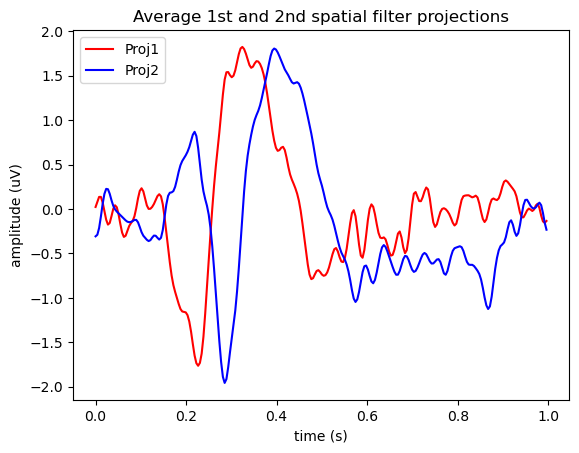

In [8]:
# Average of data (targets and non-targets)
ytf_mean = np.mean(ytf, axis=2) 
ytf_std  = np.std(ytf,axis=2);
yntf_mean = np.mean(yntf,axis=2);
yntf_std  = np.std(yntf,axis=2);

plt.plot(t,ytf_mean[0,:],'r',label='Proj1')
plt.plot(t,ytf_mean[1,:],'b', label='Proj2')
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average 1st and 2nd spatial filter projections')
plt.legend(loc = 'upper left')
plt.show()

# R-square discrimination of spatially filtered data

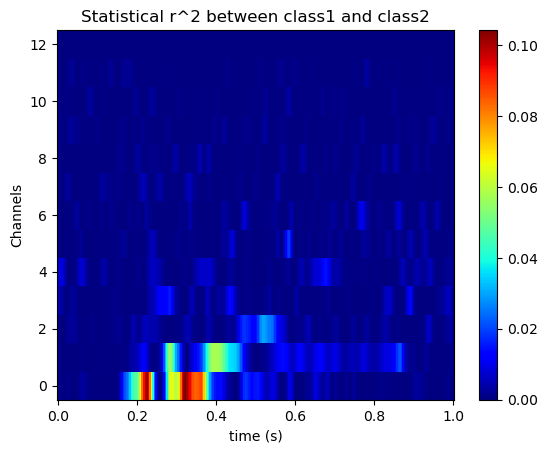

0

In [10]:
#analysis of feature discrimination with r-square of spatially filtered data
N_ch = np.size(ytf, 0);              #channels
N_samp = np.size(ytf, 1);            #time samples
rsq = np.zeros((N_samp, N_ch));     #initialize variable

for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = rsquare_fn.rsquare(ytf[ch, samp,:],yntf[ch, samp,:])

rsquare_fn.plot_rsquare(t,rsq)
#del rsq

# First Projection P300 vs non-target (standard)

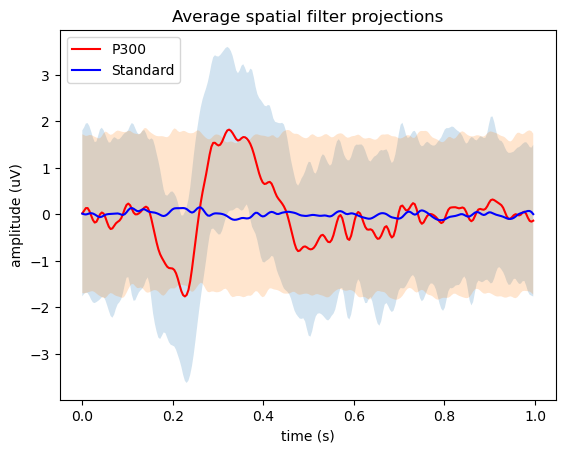

In [13]:
plt.plot(t,ytf_mean[0,:],'r',label=label1)
plt.plot(t,yntf_mean[0,:],'b', label=label2)
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average spatial filter projections')
plt.legend(loc = 'upper left')
plt.fill_between(t,ytf_mean[0,:]+ytf_std[0,:], ytf_mean[0,:]-ytf_std[0,:], alpha=0.2)
plt.fill_between(t,yntf_mean[0,:]+yntf_std[0,:], yntf_mean[0,:]-yntf_std[0,:], alpha=0.2)
plt.show()

# Feature Selection

In [15]:
#Feature selection
def sel_features(r2_scores, max_feat):
    indice=np.argsort(r2_scores)[::-1]   #descending order
    best_indice = indice[:max_feat]
    return best_indice

#selecting features based on Projection 1
best_index_feat = sel_features(rsq[:, 0],100)   #max feat = 100
#best_index_feat
#np.shape(rsq)

In [16]:
#New Feature vectors
X_class1 = ytf[0,best_index_feat,:]   #Projection1 Target  [Nfeatx90]
X_class2 = yntf[0,best_index_feat,:]  #Projection1 Non-Target [Nfeatx840]
np.shape(X_class1)
np.shape(yntf)

(12, 256, 840)

In [17]:
#Prepare features for classification
def set_class_labels(x1,x2):
    class1=np.transpose(x1)
    class2=np.transpose(x2)
    #np.shape(class1)
    #np.shape(class2)

    # Combine the class1 and class2 variables into a feature matrix X
    X = (*class1,*class2)  #np.concatenate((class1, class2), axis=0)
    np.shape(X)
   # Create the corresponding target labels
    y = [0] * len(class1) + [1] * len(class2)
    np.shape(y)
    return X,y

Xtrain, ytrain = set_class_labels(X_class1, X_class2)

# Clasification 

In [18]:
# Classification and testing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()
fit = gnb.fit(Xtrain, ytrain)

ypred = gnb.predict(Xtrain)

In [19]:
#Balanced accuracy metric - train and test same data
print("Balanced_accuracy", balanced_accuracy_score(ytrain, ypred))
#CAREFUL - THIS CAUSE OVERFITTING AS THE SAME DATA WERE USED TO TRAIN AND TEST

Balanced_accuracy 0.9126984126984127


In [20]:
balanced_accuracy_scores = cross_val_score(gnb, Xtrain, ytrain, cv=3, scoring='balanced_accuracy')
balanced_accuracy_scores
print("Mean accuracy - cross validation", np.mean(balanced_accuracy_scores))
#CAREFUL - THERE IS STILL BIAS ...

Mean accuracy - cross validation 0.9132936507936508
